In [1]:
import numpy as np
from numpy.testing import assert_equal

* Considerar retransmissão no modelo de consumo energético
* Transmissão fase-quadratura
* Desvanecimento por múltiplos percursos
* Transmissão
    * Transmissão de $X$ bits em $P$ pacotes, sem erro
    * $X/P$ bits por pacote
    * Energia para transmissão de um pacote é $E$ (uma unidade de energia)
    * Repetir transmissão de todo o pacote um bit for recebido errado

In [2]:
def add_noise(message, variance):
    n = np.size(message)
    stddev = np.sqrt(0.5 * variance)
    alpha = np.random.normal(0, stddev, n)
    codx = np.random.normal(alpha * (message.real - message.imag), stddev, n)
    cody = 1j * np.random.normal(alpha * (message.real + message.imag), stddev, n)
    return message + codx + cody

In [3]:
def demodulate(transmitted, alphabet):
    indices = np.abs(np.subtract.outer(alphabet, transmitted)).argmin(0)
    return np.asarray([alphabet[i] for i in indices])

In [10]:
# Quantidade total de bits a serem transmitidos (bits)
N = 10000

# Tamanho do pacote (bits/pacote)
Np = 100

# Símbolos 4-QAM
symbols = [1+1j, -1+1j, -1-1j, 1-1j]

# Mensagem para transmissão
message = np.random.choice(symbols, N)

In [5]:
assert_equal(demodulate(message, symbols), message)

In [6]:
%run ../wavelet.py

In [7]:
wavelet = Wavelet(m=2, g=64)
wavelet.mcw_from_coefficients('../mcw2_128.txt', Np)
alphabet = np.array([-wavelet.mg + 2 * k for k in range(wavelet.mg + 1)])

In [8]:
def qam_transmission(message, No, Np, P):
    """Performs an stream transmission using QAM scheme
    
    Parameters
    ----------
    message: stream to be transmitted
    Np: number of bits per package
    P: number of packages transmitted if no error occur
    No: system's variance
    
    Return
    ------
    Total of transmissions until every package has been delivered
    """
    assert np.size(message) % Np == 0, "message length should be a multiple of Np"
    k = 0
    cnt = 0
    while k < P:
        slice_of_message = message[k * Np: (k + 1) * Np]
        transmitted = add_noise(slice_of_message, No)
        demodulated = demodulate(transmitted, symbols)
        cnt += 1
        if np.array_equal(slice_of_message, demodulated):
            k += 1
    return cnt

def mcw_transmission(message, No, Np, P, wavelet):
    """Performs an stream transmission using QAM scheme
    
    Parameters
    ----------
    message: stream to be transmitted
    Np: number of bits per package
    P: number of packages transmitted if no error occur
    No: system's variance
    wavelet: Wavelet object initialized according to Np
    
    Return
    ------
    Total of transmissions until every package has been delivered
    """
    k = 0
    cnt = 0
    while k < P:
        slice_of_message = message[k * Np: (k + 1) * Np]
        encoding = wavelet.encode(slice_of_message.real) + 1j * wavelet.encode(slice_of_message.imag)
        transmitted = add_noise(encoding, No)
        demodulated = demodulate(transmitted.real, alphabet) + 1j * demodulate(transmitted.imag, alphabet)
        decoded = np.sign(wavelet.decode(demodulated.real)) + 1j * np.sign(wavelet.decode(demodulated.imag))
        cnt += 1
        assert_equal(np.size(slice_of_message), np.size(decoded))
        if np.array_equal(slice_of_message, decoded):
            k += 1
    return cnt

# Teste

In [13]:
# Quantidade de pacotes necessários na ausência de erro
P = N / Np

# Variância fixa (teste)
No = 0.1

print(f"No = {No}")
print(f"{P:.0f} pacotes com {Np} bits cada")
print("Energia consumida - QAM: %d * E" % qam_transmission(message, No, Np, P))
print("Energia consumida - MCW: %d * E" % mcw_transmission(message, No, Np, P, wavelet))

No = 0.1
100 pacotes com 100 bits cada
Energia consumida - QAM: 1062 * E
Energia consumida - MCW: 101 * E


# Simulação com range de variâncias

In [31]:
No = np.arange(0, 0.2, 0.01)
energy_qam = np.zeros(np.size(No))
energy_mcw = np.zeros(np.size(No))

for i, no in enumerate(No):
    energy_qam[i] = qam_transmission(message, no, Np, P)
    energy_mcw[i] = mcw_transmission(message, no, Np, P, wavelet)

<IPython.core.display.Javascript object>


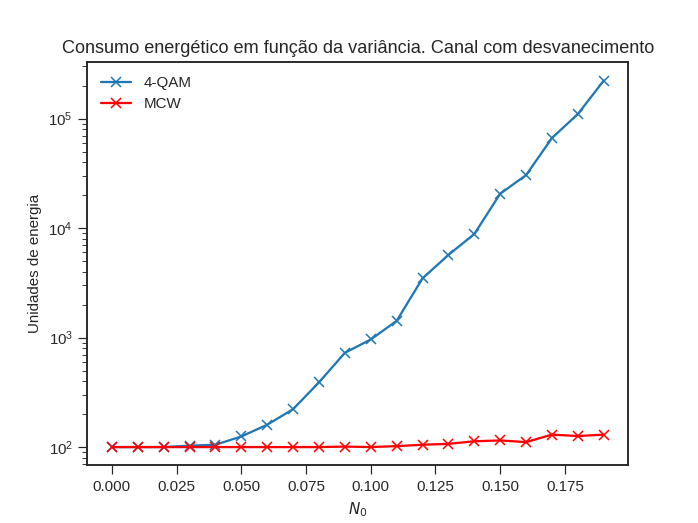

In [34]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib notebook

plt.plot(No, energy_qam, '-x', label='4-QAM')
plt.plot(No, energy_mcw, 'r-x', label='MCW')
plt.legend()
plt.xlabel('$N_0$')
plt.ylabel('Unidades de energia')
plt.yscale('log')
plt.title('Consumo energético em função da variância. Canal com desvanecimento');